In [1]:

! cd ../data/; FILELIST=" 200509 200508 200507 200506 200505 200504 200503 200502 200501 200430 200429 200428 200427 200426 200425 200424 200423 200422 200510 200511 200512 200513 200514 200515 200516 200517 200518 200519 200520 200521 200522 200523 200524 200525 200526 200527 200528 200529 200530 200609 200608 200607 200606 200605 200604 200603 200602 200601 200610 200611 200612 200613 200614 200615 200616 200617 200618 200619 200620 200621 200622 200623 200624 200625 200626 200627 200628 200629 200630 " ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ; echo $FILE:::::  ;  [ ! -f ../data/${FILE} ] && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE 1>/dev/null && ls -altr $FILE ; done 

! pwd 

200509_cam_covid19.pdf:::::
200508_cam_covid19.pdf:::::
200507_cam_covid19.pdf:::::
200506_cam_covid19.pdf:::::
200505_cam_covid19.pdf:::::
200504_cam_covid19.pdf:::::
200503_cam_covid19.pdf:::::
200502_cam_covid19.pdf:::::
200501_cam_covid19.pdf:::::
200430_cam_covid19.pdf:::::
200429_cam_covid19.pdf:::::
200428_cam_covid19.pdf:::::
200427_cam_covid19.pdf:::::
200426_cam_covid19.pdf:::::
200425_cam_covid19.pdf:::::
200424_cam_covid19.pdf:::::
200423_cam_covid19.pdf:::::
200422_cam_covid19.pdf:::::
200510_cam_covid19.pdf:::::
200511_cam_covid19.pdf:::::
200512_cam_covid19.pdf:::::
200513_cam_covid19.pdf:::::
200514_cam_covid19.pdf:::::
200515_cam_covid19.pdf:::::
200516_cam_covid19.pdf:::::
200517_cam_covid19.pdf:::::
200518_cam_covid19.pdf:::::
200519_cam_covid19.pdf:::::
200520_cam_covid19.pdf:::::
200521_cam_covid19.pdf:::::
200522_cam_covid19.pdf:::::
200523_cam_covid19.pdf:::::
200524_cam_covid19.pdf:::::
200525_cam_covid19.pdf:::::
200526_cam_covid19.pdf:::::
200527_cam_covid19.p

In [2]:
from tabula import read_pdf
import os 
import pandas as pd
import glob 
import re 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.141-1.b16.el7_3.x86_64/jre"

# Auxiliary functions
from datetime import datetime, date, time, timedelta

""" Rellenar dias vacios con interpolacion"""
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
                        datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
                        datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
                        freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    return df

def fet_daily_date_new_format(fecha): 
    df_pdf =  read_pdf('../data/'+fecha+'_cam_covid19.pdf',area=(000, 600, 400, 800) , pages='1')
    df = df_pdf[0]
    df = df['Unnamed: 0'].astype(str).str.replace(r".", '').replace("(", ' ')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]


    df = pd.DataFrame(data=df)
    df    

    dict = {}
    dict['HOSPITALES'] = df[df['Unnamed: 0'].str.contains('Hospitales')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['DOMICILIOS'] = df[df['Unnamed: 0'].str.contains('Domicilios')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['CENTROS SOCIOSANITARIOS'] = df[df['Unnamed: 0'].str.contains('Centros')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['OTROS LUGARES'] = df[df['Unnamed: 0'].str.contains('otros')].iloc[0]['Unnamed: 0'].split(' ')[0]

    cadena_a_parsear = df[df['Unnamed: 0'].str.contains('otal')].iloc[0]['Unnamed: 0']

    dict['FALLECIDOS TOTALES'] = re.search(r'(\d+)', cadena_a_parsear)[0]

    df = pd.DataFrame.from_dict(dict, orient='index').T
    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df.set_index('Fecha', inplace=True, drop=True)
    return df


def get_daily_data(fecha):
    if fecha > '200512' : 
        return fet_daily_date_new_format(fecha)
    
    col2str = {'dtype': str}
    kwargs = {'output_format': 'dataframe',
              'pandas_options': col2str,
              'stream': True}
    df_pdf =  read_pdf('../data/'+fecha+'_cam_covid19.pdf',pages='1',multiple_tables = True,**kwargs)

    
    df = df_pdf[0]

    df = df[df['Unnamed: 0'].notna()]
    df = df[(df['Unnamed: 0']=='HOSPITALES') | (df['Unnamed: 0'] == 'DOMICILIOS') | (df['Unnamed: 0'] == 'CENTROS SOCIOSANITARIOS') | (df['Unnamed: 0'] == 'OTROS LUGARES') | (df['Unnamed: 0'] == 'FALLECIDOS TOTALES')]
    df = df[['Unnamed: 0','Unnamed: 2']]
    df['Unnamed: 2'] = df['Unnamed: 2'].astype(str).str.replace(r".", '')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]

    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df = df.rename_axis(None)

    df.set_index('Fecha', inplace=True, drop=True)
    df.index
    df.dropna()
    #df = df.T
    return df

def get_all_data( ): 
    #BLACKLIST = ["200429","200422"]
    #BLACKLIST = ["200514",]
    BLACKLIST = []
    df = pd.DataFrame()
    list_df = []
 
    pdf_list= sorted(glob.glob('../data/*_cam_covid19.pdf'), 
                     key=os.path.getmtime,
                     reverse=True )
    
    for pdf_file in pdf_list:
        # extract fecha from username , eg : ../data/2200422_cam_covid19.pdf
        fecha = pdf_file.split('/')[2].split('_')[0]
        if fecha not in BLACKLIST:
            print("processing", fecha)
            df = get_daily_data(fecha) 
        list_df.append(df)

    df = pd.concat(list_df)
    df = df.astype(int)
    df = df.drop_duplicates()

    df = df.sort_values(by=['Fecha'], ascending=True)
    ###jaime
    #df = interpolate_dataframe(df,'D')
    #df.index.name = 'Fecha'

    df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
    df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
    df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)

    df = df.sort_values(by=['Fecha'], ascending=False)

    return df 

total =  get_all_data()


processing 200608
processing 200607
processing 200606
processing 200605
processing 200604
processing 200603
processing 200602
processing 200601
processing 200531
processing 200530
processing 200529
processing 200528
processing 200527
processing 200526
processing 200525
processing 200524
processing 200523
processing 200522
processing 200521
processing 200520
processing 200519
processing 200518
processing 200517
processing 200516
processing 200515
processing 200514
processing 200513
processing 200512
processing 200511
processing 200510
processing 200509
processing 200508
processing 200507
processing 200506
processing 200505
processing 200504
processing 200503
processing 200502
processing 200501
processing 200430
processing 200429
processing 200428
processing 200427
processing 200426
processing 200424
processing 200425
processing 200423
processing 200422


Got stderr: Jun 08, 2020 7:28:57 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Jun 08, 2020 7:28:57 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored
Jun 08, 2020 7:28:57 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Jun 08, 2020 7:28:57 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Jun 08, 2020 7:28:58 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored
Jun 08, 2020 7:28:58 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenT

In [3]:
total 
df = interpolate_dataframe(total,'D')
df.index.name = 'Fecha'
df = df.sort_values(by=['Fecha'], ascending=True)
df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)


df['MA CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS hoy'].rolling(window=4).mean()
df['MA HOSPITALES hoy'] = df['HOSPITALES hoy'].rolling(window=4).mean()
df['MA FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES hoy'].rolling(window=4).mean()

df = df.sort_index(ascending=False)
df_master = df.copy()



In [4]:


from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', subset= df.columns[-3:] )



Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy,MA CENTROS SOCIOSANITARIOS hoy,MA HOSPITALES hoy,MA FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,,
2020-06-08 00:00:00,"9,205",897,"4,781",27,"14,910",21,6,32,3,10,16
2020-06-07 00:00:00,"9,184",892,"4,775",27,"14,878",7,2,12,4,13,19
2020-06-06 00:00:00,"9,177",890,"4,773",27,"14,866",-2,-0,-2,6,20,28
2020-06-05 00:00:00,"9,178",890,"4,773",27,"14,868",13,5,20,8,24,35
2020-06-04 00:00:00,"9,165",888,"4,768",27,"14,848",33,10,47,7,23,32
2020-06-03 00:00:00,"9,132",885,"4,758",27,"14,801",34,11,48,6,16,24
2020-06-02 00:00:00,"9,098",881,"4,747",27,"14,753",16,5,24,4,10,15
2020-06-01 00:00:00,"9,082",879,"4,742",27,"14,729",8,3,11,4,9,15
2020-05-31 00:00:00,"9,074",878,"4,739",27,"14,718",7,4,11,6,13,21


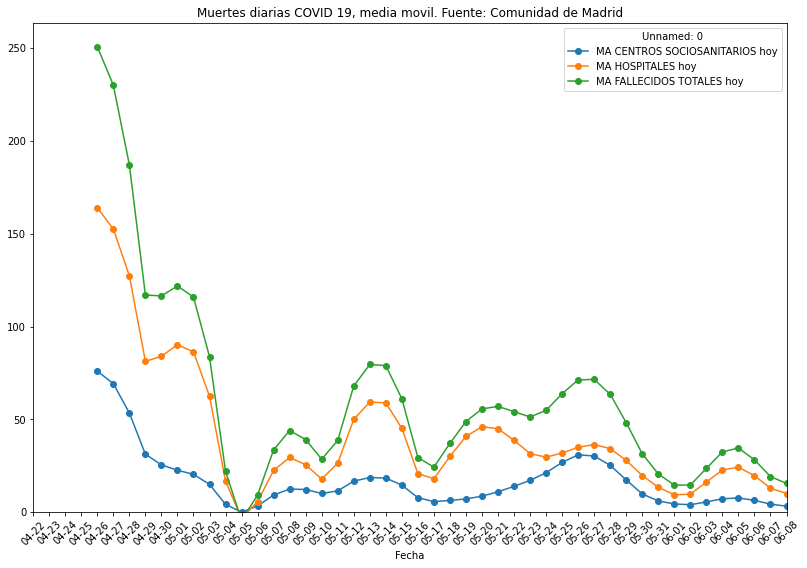

In [5]:
import pandas as pd
import io
import matplotlib.dates as mdates
from matplotlib import pyplot as plt



chart_df=df[df.columns[-3:]]
chart_df.plot(legend=True,figsize=(13.5,9), marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

ax = plt.gca()

ax.set_title("Muertes diarias COVID 19, media movil. Fuente: Comunidad de Madrid")
ax.set_ylim(ymin=0)

plt.show()



In [6]:
 from IPython.display import display, HTML
HTML("<h2>Comparamos los datos de hoy, de hace una semana y de un mes </h2>")    

In [7]:
df = df_master
pd.concat([df.head(1).tail(1) , df.head(7).tail(1) , df.head(30).tail(1)]).astype(int)[['MA HOSPITALES hoy','MA CENTROS SOCIOSANITARIOS hoy','MA FALLECIDOS TOTALES hoy']].style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', subset= df.columns[-3:] )

Unnamed: 0,MA HOSPITALES hoy,MA CENTROS SOCIOSANITARIOS hoy,MA FALLECIDOS TOTALES hoy
Fecha,,,
2020-06-08 00:00:00,10,3,15
2020-06-02 00:00:00,9,4,14
2020-05-10 00:00:00,17,10,28


In [8]:
from IPython.display import display, HTML
HTML("<h2>Muertes medias diarias, últimos 7 días, con datos</h2>")

In [9]:

from datetime import date


inicio_crisis = df.head(7).index[6]
df=df.head(7)
dia_mas_reciente = df.index[0]
dias_transcurridos_inicio_crisis = dia_mas_reciente - inicio_crisis

medias_datos = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) /  dias_transcurridos_inicio_crisis.days  ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]

df = df_master
medias_datos.astype(int)
  


Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,17,2,5,0,26


In [10]:
HTML("<h2>Muertes medias diarias desde que la comunidad de Madrid publica datos</h2>")

In [11]:
# Calculamos los incrementos medios, desde que tenemos fechas
medias_datos = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) / df.shape[0] ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
medias_datos.astype(int)

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,42,2,17,0,63
